In [1]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.utils import shuffle
import pandas as pd

In [2]:
class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		self.conv1 = nn.Conv2d(1, 4, (5,5))
		self.conv2 = nn.Conv2d(4, 12, (5,5))
		self.fc1   = nn.Linear(12*4*4, 10)
	def forward(self, x):
		x = nn.AvgPool2d((2,2))(F.relu(self.conv1(x)))
		x = nn.AvgPool2d((2,2))(F.relu(self.conv2(x)))
		x = x.view(-1, self.num_flat_features(x))
		x = self.fc1(x)
		return x
	def num_flat_features(self, x):
		size = x.size()[1:]
		num_features = 1
		for s in size:
			num_features *= s
		return num_features

In [3]:
net = LeNet()
print (net)

LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=10, bias=True)
)


In [4]:
use_gpu = torch.cuda.is_available()
if use_gpu:
	net = net.cuda()
	print ('USE GPU')
else:
	print ('USE CPU')

USE GPU


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [6]:
print ("1. Loading data")
train_data = pd.read_csv("../train.csv").values
train_data = shuffle(train_data)

train_samples = train_data.shape[0]
train = train_data[:int(0.8*train_samples),:]
cv_set = train_data[int(0.8*train_samples):,:]
test  = pd.read_csv("../test.csv").values

1. Loading data


In [7]:
print ("2. Converting data")
X_data  = train[:, 1:].reshape(train.shape[0], 1, 28, 28)
X_data  = X_data.astype(float)
X_data /= 255.0
X_data  = torch.from_numpy(X_data);
X_label = train[:,0];
X_label = X_label.astype(int);
X_label = torch.from_numpy(X_label);
X_label = X_label.view(train.shape[0],-1);
print (X_data.size(), X_label.size())

2. Converting data
torch.Size([33600, 1, 28, 28]) torch.Size([33600, 1])


In [8]:
print ("3. Training phase")
nb_train = train.shape[0]
nb_epoch = 75000
nb_index = 0
nb_batch = 4

3. Training phase


In [9]:
for epoch in range(nb_epoch):
	if nb_index + nb_batch >= nb_train:
		nb_index = 0
	else:
		nb_index = nb_index + nb_batch

	mini_data  = Variable(X_data[nb_index:(nb_index+nb_batch)].clone())
	mini_label = Variable(X_label[nb_index:(nb_index+nb_batch)].clone(), requires_grad = False)
	mini_data  = mini_data.type(torch.FloatTensor)
	mini_label = mini_label.type(torch.LongTensor)
	if use_gpu:
		mini_data  = mini_data.cuda()
		mini_label = mini_label.cuda()
	optimizer.zero_grad()
	mini_out   = net(mini_data)
	mini_label = mini_label.view(nb_batch)
	mini_loss  = criterion(mini_out, mini_label)
	mini_loss.backward()
	optimizer.step()
	if (epoch + 1) % 2000 == 0:
		print("Epoch = %d, Loss = %f" %(epoch+1, mini_loss.data.item()))

Epoch = 2000, Loss = 2.218792
Epoch = 4000, Loss = 1.911919
Epoch = 6000, Loss = 0.406669
Epoch = 8000, Loss = 0.368798
Epoch = 10000, Loss = 0.228770
Epoch = 12000, Loss = 0.255846
Epoch = 14000, Loss = 0.122689
Epoch = 16000, Loss = 0.161476
Epoch = 18000, Loss = 0.664425
Epoch = 20000, Loss = 0.417692
Epoch = 22000, Loss = 0.052866
Epoch = 24000, Loss = 0.117880
Epoch = 26000, Loss = 0.034785
Epoch = 28000, Loss = 1.077461
Epoch = 30000, Loss = 0.005547
Epoch = 32000, Loss = 0.100642
Epoch = 34000, Loss = 0.024552
Epoch = 36000, Loss = 0.004153
Epoch = 38000, Loss = 2.046187
Epoch = 40000, Loss = 0.179094
Epoch = 42000, Loss = 0.171298
Epoch = 44000, Loss = 0.001641
Epoch = 46000, Loss = 0.137287
Epoch = 48000, Loss = 0.087506
Epoch = 50000, Loss = 0.284771
Epoch = 52000, Loss = 0.009548
Epoch = 54000, Loss = 0.056597
Epoch = 56000, Loss = 0.044730
Epoch = 58000, Loss = 0.058018
Epoch = 60000, Loss = 0.255537
Epoch = 62000, Loss = 0.160438
Epoch = 64000, Loss = 0.000300
Epoch = 6600

In [10]:
print ("4. Preparing Cross Validation")

cv_data  = cv_set[:, 1:].reshape(cv_set.shape[0], 1, 28, 28)
cv_data  = cv_data.astype(float)
cv_data /= 255.0
cv_data  = torch.from_numpy(cv_data);
cv_label = cv_set[:,0];
cv_label = cv_label.astype(int);
cv_label = torch.from_numpy(cv_label);
cv_label = cv_label.view(cv_set.shape[0],-1);
print (cv_data.size(), cv_label.size())

4. Preparing Cross Validation
torch.Size([8400, 1, 28, 28]) torch.Size([8400, 1])


In [11]:
nb_train = cv_set.shape[0]
nb_index = 0
nb_batch = 4

In [12]:
error = 0

for nb_index in range(0, nb_train, nb_batch):
	mini_data  = Variable(X_data[nb_index:(nb_index+nb_batch)].clone(), requires_grad = False)
	mini_label = Variable(X_label[nb_index:(nb_index+nb_batch)].clone(), requires_grad = False)
	mini_data  = mini_data.type(torch.FloatTensor)
	mini_label = mini_label.type(torch.LongTensor)
	if use_gpu:
		mini_data  = mini_data.cuda()
		mini_label = mini_label.cuda()
	mini_out   = net(mini_data)
	output_label = mini_out.argmax(1)
	mini_label = mini_label.view(nb_batch)
	is_match = torch.eq(output_label, mini_label)
	total = torch.sum(is_match).item()
	error += nb_batch - total
	if (nb_index + 1) % 500 == 0:
		print("Epoch = %d" %(error))

In [13]:
print(error)
print ("5. Testing phase")

Y_data  = test.reshape(test.shape[0], 1, 28, 28)
Y_data  = Y_data.astype(float)
Y_data /= 255.0
Y_data  = torch.from_numpy(Y_data);
print (Y_data.size())
nb_test = test.shape[0]

net.eval()

291
5. Testing phase
torch.Size([28000, 1, 28, 28])


LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=10, bias=True)
)

7
Total tested = 2000
7
Total tested = 4000
4
Total tested = 6000
0
Total tested = 8000
7
Total tested = 10000
5
Total tested = 12000
0
Total tested = 14000
2
Total tested = 16000
4
Total tested = 18000
6
Total tested = 20000
4
Total tested = 22000
1
Total tested = 24000
4
Total tested = 26000
2
Total tested = 28000


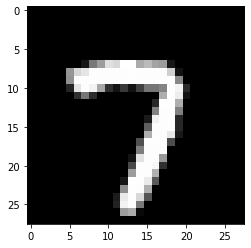

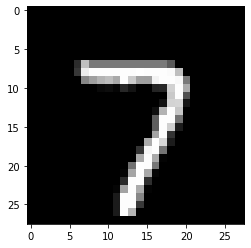

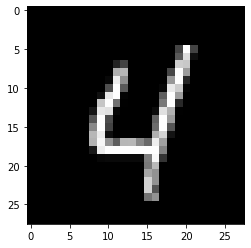

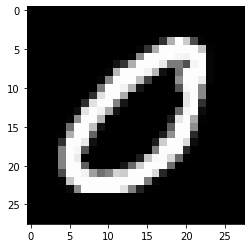

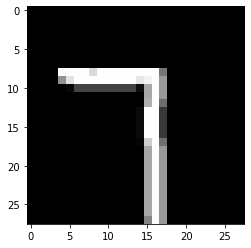

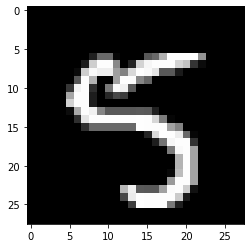

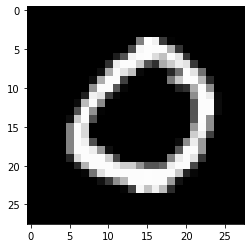

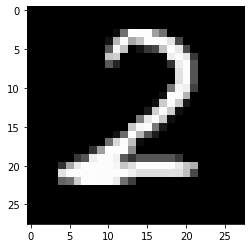

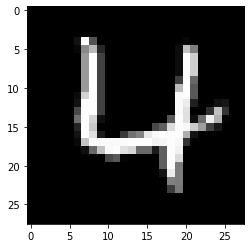

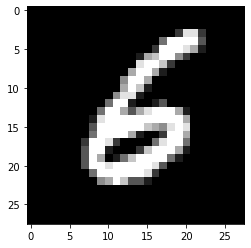

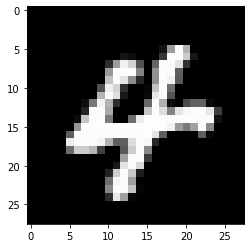

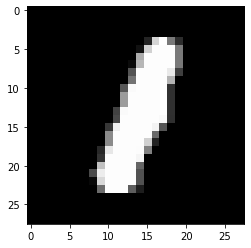

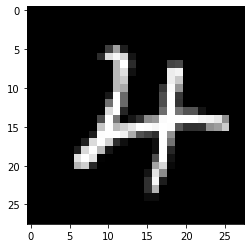

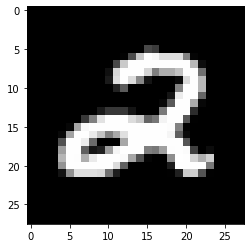

In [14]:
final_prediction = np.ndarray(shape = (nb_test, 2), dtype=int)
counter = 0
for each_sample in range(nb_test):
	sample_data = Variable(Y_data[each_sample:each_sample+1].clone())
	sample_data = sample_data.type(torch.FloatTensor)
	if use_gpu:
		sample_data = sample_data.cuda()
	sample_out = net(sample_data)
	_, pred = torch.max(sample_out, 1)
	final_prediction[each_sample][0] = 1 + each_sample
	final_prediction[each_sample][1] = pred.data.item()
	if (each_sample + 1) % 2000 == 0:
		plt.figure()
		plt.imshow(sample_data.cpu().reshape(28,28), cmap='gray')
		print(final_prediction[each_sample][1])
		print("Total tested = %d" %(each_sample + 1))

In [15]:
print ('6. Generating submission file')

submission = pd.DataFrame(final_prediction, dtype=int, columns=['ImageId', 'Label'])
submission.to_csv('../pytorch_LeNet.csv', index=False, header=True)

6. Generating submission file


In [16]:
weights = []

for name, param in net.named_parameters():
    weights = param.cpu()
    weights = weights.detach().numpy()
    size = 1
    for dim in weights.shape[1:]:
        size *= dim
    weights  = weights.reshape(weights.shape[0], size)
    pd.DataFrame(weights).to_csv( name + '.csv' )